In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras import Sequential, layers, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import sparse_categorical_crossentropy


In [2]:
df = pd.read_csv('../data/data_clean.csv')
df.head(5)

/var/folders/nj/s1c8f0tj3ksfjdg8xyxr6rdc0000gn/T/ipykernel_59736/2597316256.py:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/data_clean.csv')


,uid,id,nature,acheteur_id,acheteur_nom,acheteur_siren,titulaire_id,titulaire_typeIdentifiant,titulaire_nom,titulaire_siren,...,codeCPV_2,codeCPV_3,codeCPV_4,codeCPV_5,codeCPV_2_3,annee,acheteur_tranche_effectif,acheteur_categorie,titulaire_tranche_effectif,titulaire_categorie
0,2154005160001320242024-LOT04,20242024-LOT04,Marché,21540051600013,COMMUNE DE BATILLY,215400516.0,78885470100018,SIRET,ACOMETAL,788854701.0,...,45000000,45200000,45260000,45261000,45200000,2024,12,PME,03,PME
1,243500667002882021M226MO,2021M226MO,Marché,24350066700288,CC VAL D'ILLE-AUBIGNE,243500667.0,38373211200032,SIRET,UNIVERS,383732112.0,...,71000000,71200000,71200000,71200000,71200000,2021,22,PME,03,PME
2,249710047000472024SS_PRD_TRV,2024SS_PRD_TRV,Marché,24971004700047,COMMUNAUTE DE COMMUNES DE MARIE GALANTE,249710047.0,43387249600016,SIRET,COTRAM B.T.P.,433872496.0,...,45000000,45200000,45230000,45232000,45200000,2024,12,PME,12,PME
3,6254801990001124-0806-L2,24-0806-L2,Marché,62548019900011,"LA MAISON POUR TOUS, SOCIETE ANONYME COOPERATI...",625480199.0,55204695502544,SIRET,ENGIE ENERGIE SERVICES,552046955.0,...,50000000,50700000,50720000,50720000,50000000,2024,22,ETI,53,GE
4,20002563300013202424011BCR,202424011BCR,Marché,20002563300013,SI DE RESTAURATION COLLECTIVE,200025633.0,47698032100238,SIRET,POMONA EPISAVEURS,476980321.0,...,15000000,15800000,15800000,15800000,15000000,2024,12,PME,42,GE


In [4]:
from scripts.data_cleaner import filter_top_cpv_categories

df = filter_top_cpv_categories(df, top_n=150, cpv_column='codeCPV_3')

Filtered from 392 to 150 CPV categories, keeping 279174 rows out of 286850


In [5]:
df.drop(df[df['montant'] > 999999].index, inplace=True)
df.shape

(238163, 42)

In [6]:
y = np.log1p(df['montant'])
y.head()

0    11.292279
1    10.882925
4    13.235694
5    11.350889
6    12.044412
Name: montant, dtype: float64

In [7]:
bins = np.linspace(y.min(), y.max(), 10)

# Créer les étiquettes correspondantes
labels = list(range(1, len(bins)))

# Ajouter la colonne fourchette_de_prix
df['bins'] = pd.cut(y, bins=bins, labels=labels, include_lowest=True, right=True)

df.shape

(238163, 43)

In [10]:
df['bins'] = df['bins'].astype('int')
df = df.drop(columns='montant')
df.columns

Index(['uid', 'id', 'nature', 'acheteur_id', 'acheteur_nom', 'acheteur_siren',
       'titulaire_id', 'titulaire_typeIdentifiant', 'titulaire_nom',
       'titulaire_siren', 'objet', 'codeCPV', 'procedure', 'dureeMois',
       'dateNotification', 'datePublicationDonnees', 'formePrix',
       'attributionAvance', 'offresRecues', 'marcheInnovant', 'ccag',
       'sousTraitanceDeclaree', 'typeGroupementOperateurs', 'tauxAvance',
       'origineUE', 'origineFrance', 'lieuExecution_code',
       'lieuExecution_typeCode', 'idAccordCadre', 'source_open_data',
       'codeCPV_FR', 'codeCPV_2', 'codeCPV_3', 'codeCPV_4', 'codeCPV_5',
       'codeCPV_2_3', 'annee', 'acheteur_tranche_effectif',
       'acheteur_categorie', 'titulaire_tranche_effectif',
       'titulaire_categorie', 'bins'],
      dtype='object')

In [13]:
X = df.drop(columns=['bins', 'titulaire_tranche_effectif', 'titulaire_categorie'])
y = df['bins']

In [16]:
df[['acheteur_tranche_effectif', 'acheteur_categorie']] = df[['acheteur_tranche_effectif', 'acheteur_categorie']].fillna('null')
df[['acheteur_tranche_effectif', 'acheteur_categorie']].isna().sum()

acheteur_tranche_effectif    0
acheteur_categorie           0
dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=X['codeCPV_3'])

In [19]:
from scripts.preprocess_pipeline import create_pipeline

numerical_columns = ['dureeMois', 'offresRecues', 'annee']

binary_columns = ['sousTraitanceDeclaree', 'origineFrance',
                          'marcheInnovant', 'idAccordCadre']

categorical_columns = ['procedure', 'nature', 'formePrix', 'ccag',
                               'typeGroupementOperateurs', 'tauxAvance_cat',
                               'codeCPV_3', 'acheteur_tranche_effectif', 'acheteur_categorie']

pipeline = create_pipeline(numerical_columns, binary_columns, categorical_columns)

In [20]:
X_train_preproc = pipeline.fit_transform(X_train)
X_train_preproc.shape

(190530, 220)

In [21]:
from keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_train_cat.shape

(190530, 10)

In [25]:
# Dimensions
input_dim = 220
num_classes = 10

# Modèle MLP
model = Sequential()

model.add(Input(shape=(input_dim,)))

model.add(layers.Dense(512, activation='relu', input_shape=(input_dim,)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(num_classes, activation='softmax'))  # Sortie pour classification

# Compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # ou 'categorical_crossentropy' si y est one-hot
    metrics=['accuracy']
)

# Affichage du résumé du modèle
model.summary()

/Users/paulcolas/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │       113,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,250 (1.08 MB)

 Trainable params: 280,458 (1.07 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [26]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
        X_train_preproc, y_train_cat,
        validation_split=0.2,
        batch_size=32,
        epochs=100,
        callbacks=[es],
        verbose=1)

Epoch 1/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.1817 - loss: 2.1772 - val_accuracy: 0.2084 - val_loss: 1.9668
Epoch 2/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2071 - loss: 1.9748 - val_accuracy: 0.2144 - val_loss: 1.9510
Epoch 3/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2125 - loss: 1.9575 - val_accuracy: 0.2220 - val_loss: 1.9404
Epoch 4/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2212 - loss: 1.9425 - val_accuracy: 0.2265 - val_loss: 1.9300
Epoch 5/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2264 - loss: 1.9305 - val_accuracy: 0.2276 - val_loss: 1.9267
Epoch 6/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.2322 - loss: 1.9223 - val_accuracy: 0.2339 - val_loss: 1.9213
Epoch 7/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2381 - loss: 1.9096 - val_accuracy: 0.2351 - val_loss: 1.9152
Epoch 8/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2410 - 

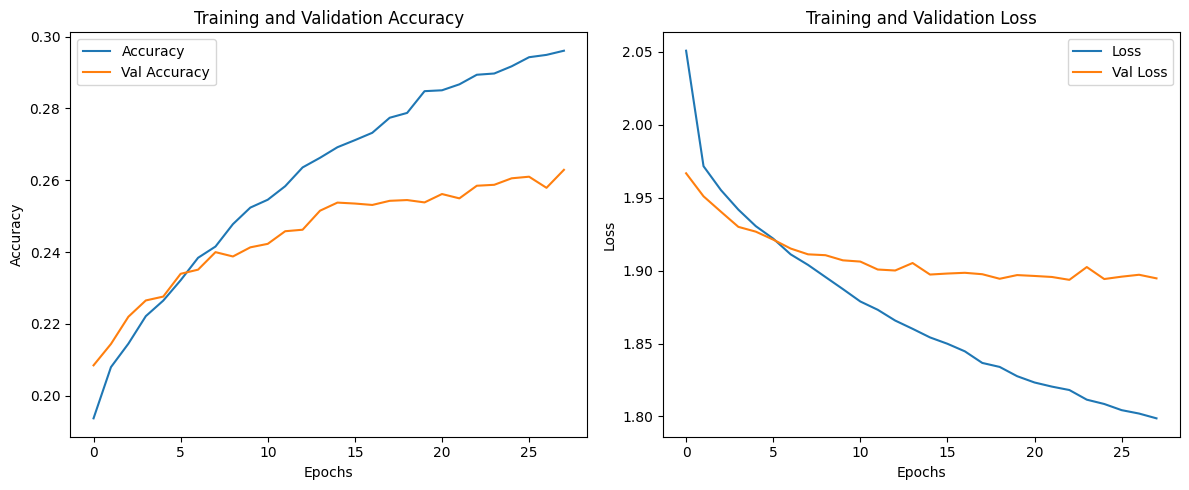

In [27]:
# Récupération des données d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création de la figure
plt.figure(figsize=(12, 5))

# Plot de l'accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot de la loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Affichage
plt.tight_layout()
plt.show()

In [28]:
# Dimensions
input_dim = 220
num_classes = 10

# Modèle MLP
model = Sequential()

model.add(Input(shape=(input_dim,)))

model.add(layers.Dense(1028, activation='relu',))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(num_classes, activation='softmax'))  # Sortie pour classification

# Compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # ou 'categorical_crossentropy' si y est one-hot
    metrics=['accuracy']
)

# Affichage du résumé du modèle
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 1028)           │       227,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1028)           │         4,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 895,118 (3.41 MB)

 Trainable params: 891,526 (3.40 MB)

 Non-trainable params: 3,592 (14.03 KB)

In [29]:
es = EarlyStopping(patience=5, restore_best_weights=True, min_delta=1e-3)

history2 = model.fit(
        X_train_preproc, y_train_cat,
        validation_split=0.2,
        batch_size=32,
        epochs=100,
        callbacks=[es],
        verbose=1)

Epoch 1/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.1825 - loss: 2.2296 - val_accuracy: 0.2117 - val_loss: 1.9799
Epoch 2/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.2063 - loss: 1.9852 - val_accuracy: 0.2069 - val_loss: 1.9581
Epoch 3/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.2140 - loss: 1.9561 - val_accuracy: 0.2215 - val_loss: 1.9409
Epoch 4/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 55s 12ms/step - accuracy: 0.2212 - loss: 1.9423 - val_accuracy: 0.2233 - val_loss: 1.9330
Epoch 5/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.2294 - loss: 1.9274 - val_accuracy: 0.2263 - val_loss: 1.9246
Epoch 6/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.2348 - loss: 1.9168 - val_accuracy: 0.2364 - val_loss: 1.9169
Epoch 7/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.2422 - loss: 1.9012 - val_accuracy: 0.2425 - val_loss: 1.9096
Epoch 8/100
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.2477 

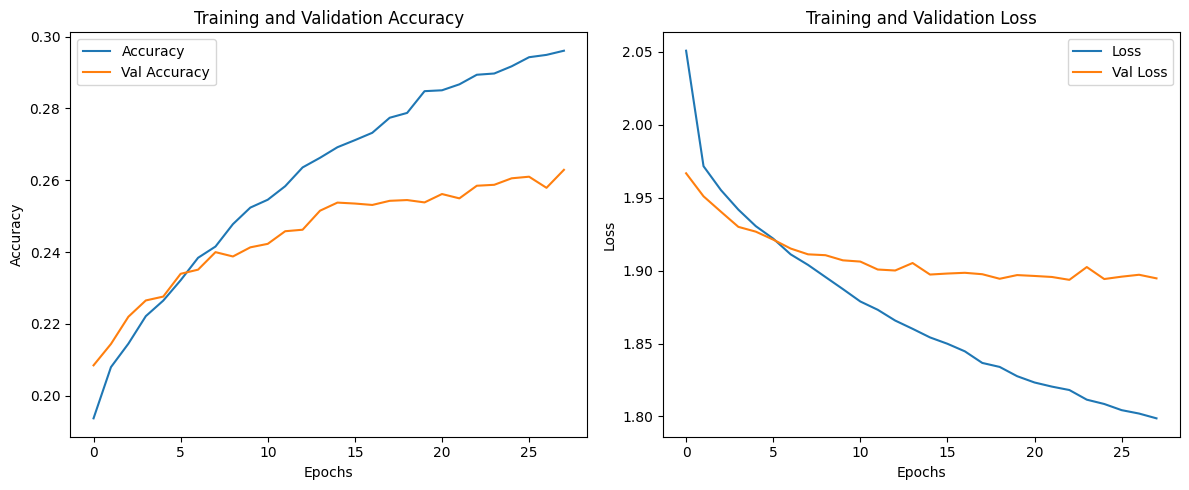

In [30]:
# Récupération des données d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création de la figure
plt.figure(figsize=(12, 5))

# Plot de l'accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot de la loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Affichage
plt.tight_layout()
plt.show()

In [40]:
# Dimensions
input_dim = 220
num_classes = 10

# Modèle MLP
model = Sequential()

model.add(Input(shape=(input_dim,)))

model.add(layers.Dense(1028, activation='relu',))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(num_classes, activation='softmax'))  # Sortie pour classification

# Compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # ou 'categorical_crossentropy' si y est one-hot
    metrics=['accuracy']
)

# Affichage du résumé du modèle
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 1028)           │       227,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1028)           │         4,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 895,118 (3.41 MB)

 Trainable params: 891,526 (3.40 MB)

 Non-trainable params: 3,592 (14.03 KB)

In [41]:
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

In [42]:
history3 = model.fit(
    X_train_preproc, y_train_cat,
    validation_split=0.2,
    batch_size=128,
    epochs=100,
    callbacks=[early_stop, lr_scheduler],
)

Epoch 1/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.1766 - loss: 2.3386 - val_accuracy: 0.2091 - val_loss: 1.9758 - learning_rate: 0.0010
Epoch 2/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2094 - loss: 1.9797 - val_accuracy: 0.2165 - val_loss: 1.9521 - learning_rate: 0.0010
Epoch 3/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2141 - loss: 1.9600 - val_accuracy: 0.2181 - val_loss: 1.9438 - learning_rate: 0.0010
Epoch 4/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2175 - loss: 1.9515 - val_accuracy: 0.2205 - val_loss: 1.9363 - learning_rate: 0.0010
Epoch 5/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2231 - loss: 1.9345 - val_accuracy: 0.2265 - val_loss: 1.9320 - learning_rate: 0.0010
Epoch 6/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2283 - loss: 1.9259 - val_accuracy: 0.2314 - val_loss: 1.9202 - learning_rate: 0.0010
Epoch 7/100
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2

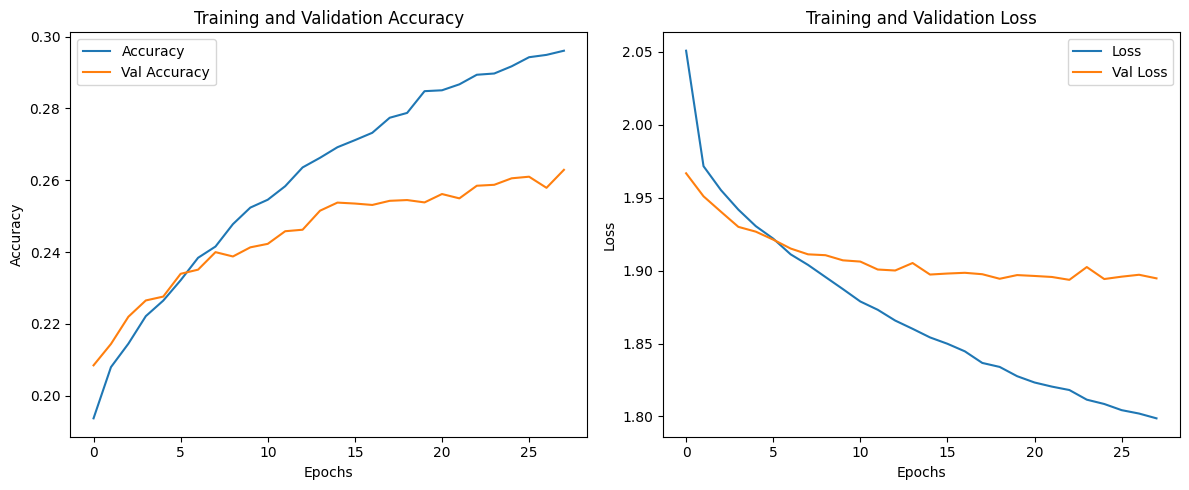

In [43]:
# Récupération des données d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création de la figure
plt.figure(figsize=(12, 5))

# Plot de l'accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot de la loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Affichage
plt.tight_layout()
plt.show()